# Note to TA: ↓↓↓↓↓ CHANGE THIS FIRST ↓↓↓↓↓

In [1]:
TRAIN_DSET_PATH = "./datasets/train.csv"
TEST_DSET_PATH  = "./datasets/test.csv"
OUTPUT_PATH     = "./2020_11_30_a.csv"

# Note to TA: ↑↑↑↑↑ CHANGE THIS FIRST ↑↑↑↑↑

# 0. Functions for cross-validation

summarize:

takes a model and a dataset and prints the F1 score, precision, recall, confusion matrix and ROC-AUC score



cross_validate:

runs stratified k-fold cross validation using a given model and a given dataset

In [2]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def summarize(model, X, y, modelapi="sklearn"):
    yhat_probs = model.predict_proba(X)[:,1]

    print("ROC AUC score:", roc_auc_score(y, yhat_probs))
    print("ROC AUC curve:")
    fpr, tpr, thresholds = roc_curve(y, yhat_probs)
    plt.plot(fpr, tpr, color="red")
    plt.plot(fpr, fpr, color="blue")
    plt.show()

    return roc_auc_score(y, yhat_probs)

def cross_validate(model, n_folds, X, y, modelapi="sklearn"):
    kfcv = StratifiedKFold(n_splits=n_folds)
    i = 0
    validation_roc_auc = []
    for train_indices, test_indices in kfcv.split(X,y):
        print("Round number", i)
        i += 1
        trainset_X = X[train_indices,:]
        testset_X  = X[test_indices,:]
        trainset_y = y[train_indices]
        testset_y  = y[test_indices]
        model.fit(trainset_X, trainset_y)
        print("\n\nTraining:")
        summarize(model,trainset_X, trainset_y)
        print("Testing:")
        validation_roc_auc.append(summarize(model, testset_X, testset_y))
        print(("-"*15))
    validation_roc_auc = np.array(validation_roc_auc)
    print("Mean validation AUROC:", np.mean(validation_roc_auc))
    print("Median validation AUROC:", np.median(validation_roc_auc))
    print("Min validation AUROC:", np.min(validation_roc_auc))
    print("Max validation AUROC:", np.max(validation_roc_auc))

# 1. Preprocessing

Strategy:

A. Drop excess null value columns.

B. Impute the null values in the remaining columns to either:

a. The mode of that class 

b. The value which contextually makes sense for that column. E.g if there is a column battery_type, NA might mean -- no battery.

C. One-hot-encode remaining columns


In a few columns, multiple values have the same semantic meaning, like "Unknown" and "Not specified". These have been combined.

The display-resolution columns could be better engineered into:

i.    The diagonal in inches 

ii.   The aspect ratio (16:9 vs 4:3  etc)
    
iii.  The number of pixels

## 1.0. Pandas and dataset imports

In [3]:
import numpy as np 
import pandas as pd 
import gc

train_dset_df = pd.read_csv(TRAIN_DSET_PATH)
test_dset_df  = pd.read_csv(TEST_DSET_PATH)

train_Y = train_dset_df.HasDetections.to_numpy()

/home/akb/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1.1. Data entry

The information on imputation etc was originally kept in .csv files, however, for the sake of portability, the resulting information is being entered in the notebook.

preprocessing_df stores whether to keep column as is, label encode, one-hot encode, do something custom, do null value imputation or drop.

imputation_df stores the value which should fill the NAs in a specified column

In [4]:
from io import StringIO

In [5]:
preprocessing_str = """feature_name,keep_as_is,label_encode,one_hot_encode,custom_encode,null_value_impute,drop
MachineIdentifier,0,0,0,0,0,1
ProductName,0,0,1,0,0,0
EngineVersion,0,0,1,0,0,0
AppVersion,0,0,1,0,0,0
AvSigVersion,0,0,1,0,0,0
IsBeta,1,0,0,0,0,0
RtpStateBitfield,0,0,1,0,1,0
IsSxsPassiveMode,1,0,0,0,0,0
DefaultBrowsersIdentifier,0,0,0,0,0,1
AVProductStatesIdentifier,0,0,1,0,1,0
AVProductsInstalled,1,0,0,0,1,0
AVProductsEnabled,1,0,0,0,1,0
HasTpm,1,0,0,0,0,0
CountryIdentifier,0,0,1,0,0,0
CityIdentifier,0,0,0,0,0,1
OrganizationIdentifier,0,0,0,0,0,1
GeoNameIdentifier,0,0,1,0,1,0
LocaleEnglishNameIdentifier,0,0,1,0,0,0
Platform,0,0,1,0,0,0
Processor,0,0,1,0,0,0
OsVer,0,0,1,0,0,0
OsBuild,0,0,1,0,0,0
OsSuite,0,0,1,0,0,0
OsPlatformSubRelease,0,0,1,0,0,0
OsBuildLab,0,0,1,0,1,0
SkuEdition,0,0,1,0,0,0
IsProtected,1,0,0,0,1,0
AutoSampleOptIn,1,0,0,0,0,0
PuaMode,0,0,0,0,0,1
SMode,1,0,0,0,1,0
IeVerIdentifier,0,0,1,0,1,0
SmartScreen,0,0,0,1,1,0
Firewall,1,0,0,0,1,0
UacLuaenable,0,0,1,0,1,0
Census_MDC2FormFactor,0,0,1,0,0,0
Census_DeviceFamily,0,0,1,0,0,0
Census_OEMNameIdentifier,0,0,1,0,1,0
Census_OEMModelIdentifier,0,0,1,0,1,0
Census_ProcessorCoreCount,1,0,0,0,1,0
Census_ProcessorManufacturerIdentifier,0,0,1,0,1,0
Census_ProcessorModelIdentifier,0,0,1,0,1,0
Census_ProcessorClass,0,0,0,0,0,1
Census_PrimaryDiskTotalCapacity,1,0,0,0,1,0
Census_PrimaryDiskTypeName,0,0,0,1,1,0
Census_SystemVolumeTotalCapacity,1,0,0,0,1,0
Census_HasOpticalDiskDrive,1,0,0,0,0,0
Census_TotalPhysicalRAM,1,0,0,0,1,0
Census_ChassisTypeName,0,0,1,0,1,0
Census_InternalPrimaryDiagonalDisplaySizeInInches,1,0,0,0,0,0
Census_InternalPrimaryDisplayResolutionHorizontal,0,0,0,1,1,0
Census_InternalPrimaryDisplayResolutionVertical,0,0,0,1,1,0
Census_PowerPlatformRoleName,0,0,1,0,1,0
Census_InternalBatteryType,0,0,1,0,1,0
Census_InternalBatteryNumberOfCharges,1,0,0,0,1,0
Census_OSVersion,0,0,1,0,0,0
Census_OSArchitecture,0,0,0,0,0,1
Census_OSBranch,0,0,1,0,0,0
Census_OSBuildNumber,0,0,1,0,0,0
Census_OSBuildRevision,0,0,1,0,0,0
Census_OSEdition,0,0,1,0,0,0
Census_OSSkuName,0,0,1,0,0,0
Census_OSInstallTypeName,0,0,1,0,0,0
Census_OSInstallLanguageIdentifier,0,0,1,0,1,0
Census_OSUILocaleIdentifier,0,0,1,0,0,0
Census_OSWUAutoUpdateOptionsName,0,0,1,0,0,0
Census_IsPortableOperatingSystem,1,0,0,0,0,0
Census_GenuineStateName,0,0,1,0,0,0
Census_ActivationChannel,0,0,1,0,0,0
Census_IsFlightingInternal,0,0,0,0,0,1
Census_IsFlightsDisabled,1,0,0,0,1,0
Census_FlightRing,0,0,1,0,0,0
Census_ThresholdOptIn,0,0,0,0,0,1
Census_FirmwareManufacturerIdentifier,0,0,1,0,1,0
Census_FirmwareVersionIdentifier,0,0,0,0,0,1
Census_IsSecureBootEnabled,1,0,0,0,0,0
Census_IsWIMBootEnabled,0,0,0,0,0,1
Census_IsVirtualDevice,1,0,0,0,1,0
Census_IsTouchEnabled,1,0,0,0,0,0
Census_IsPenCapable,1,0,0,0,0,0
Census_IsAlwaysOnAlwaysConnectedCapable,1,0,0,0,1,0
Wdft_IsGamer,1,0,0,0,1,0
Wdft_RegionIdentifier,0,0,1,0,1,0
HasDetections,1,0,0,0,0,0
"""

preprocessing_str_io = StringIO(preprocessing_str)
preprocessing_df = pd.read_csv(preprocessing_str_io)
preprocessing_df.set_index("feature_name", inplace=True)



In [6]:
imputation_str="""col_name,value_to_fill
AVProductStatesIdentifier,53447.0
GeoNameIdentifier,277.0
OsBuildLab,17134.1.amd64fre.rs4_release.180410-1804
IeVerIdentifier,137.0
Census_OEMNameIdentifier,2668.0
Census_OEMModelIdentifier,313586.0
Census_ProcessorModelIdentifier,1998.0
Census_InternalBatteryType,none
Census_FirmwareManufacturerIdentifier,142.0
RtpStateBitfield,7
AVProductsInstalled,0
AVProductsEnabled,1
IsProtected,0
SMode,0
SmartScreen,off
Firewall,0
UacLuaenable,0
Census_ProcessorCoreCount,4
Census_ProcessorManufacturerIdentifier,5
Census_PrimaryDiskTotalCapacity,1000000
Census_PrimaryDiskTypeName,UNKNOWN
Census_SystemVolumeTotalCapacity,600000
Census_TotalPhysicalRAM,40000
Census_ChassisTypeName,UNKNOWN
Census_InternalPrimaryDisplayResolutionHorizontal,1000
Census_InternalPrimaryDisplayResolutionVertical,1000
Census_PowerPlatformRoleName,UNKNOWN
Census_InternalBatteryNumberOfCharges,1096828554
Census_OSInstallLanguageIdentifier,8
Census_IsFlightsDisabled,0
Census_IsVirtualDevice,0
Census_IsAlwaysOnAlwaysConnectedCapable,0
Wdft_IsGamer,0
Wdft_RegionIdentifier,10
"""

imputation_str_io = StringIO(imputation_str)
imputation_df = pd.read_csv(imputation_str_io)


## 1.2. Dropping columns

In [7]:
for column in preprocessing_df.index:
    if(preprocessing_df.loc[column, "drop"] == 1):
        train_dset_df.drop(axis="columns", inplace=True, labels=[column])
        test_dset_df.drop(axis="columns", inplace=True, labels=[column])

## 1.3. Imputing null values

In [8]:
for i in range(len(imputation_df)):
    try:
        imputation_df["value_to_fill"][i] = int(imputation_df["value_to_fill"][i])
    except:
        pass
        

In [9]:
imputation_df.set_index("col_name", inplace=True)

In [10]:
for column in imputation_df.index:
    train_dset_df[column].fillna(imputation_df.value_to_fill[column], inplace=True)
    test_dset_df[column].fillna(imputation_df.value_to_fill[column], inplace=True)


## 1.4. Custom preprocessing some columns before one-hot encoding

### 1.4.1. Smartscreen

In [11]:
train_dset_df.SmartScreen.unique()

array(['off', 'RequireAdmin', 'ExistsNotSet', 'Off', 'Warn', 'Prompt',
       'Block', '&#x02;', '&#x01;', 'On', 'on', 'requireadmin', 'prompt',
       'Enabled'], dtype=object)

In [12]:
train_dset_df.SmartScreen = train_dset_df.SmartScreen.apply(lambda x: x.lower())
train_dset_df.SmartScreen[train_dset_df.SmartScreen == "enabled"] = "on"
train_dset_df.SmartScreen[train_dset_df.SmartScreen == '&#x02;'] = "off"
train_dset_df.SmartScreen[train_dset_df.SmartScreen == '&#x01;'] = "off"

/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after remo

In [13]:
test_dset_df.SmartScreen = test_dset_df.SmartScreen.apply(lambda x: x.lower())
test_dset_df.SmartScreen[test_dset_df.SmartScreen == "enabled"] = "on"
test_dset_df.SmartScreen[test_dset_df.SmartScreen == '&#x02;'] = "off"
test_dset_df.SmartScreen[test_dset_df.SmartScreen == '&#x01;'] = "off"

/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after remo

In [14]:
test_dset_df.SmartScreen.unique()

array(['off', 'requireadmin', 'existsnotset', 'warn', 'block', 'prompt',
       'on'], dtype=object)

### 1.4.2. Census_PrimaryDiskTypeName

In [15]:
train_dset_df.Census_PrimaryDiskTypeName[train_dset_df.Census_PrimaryDiskTypeName == "Unspecified"] = "UNKNOWN"
test_dset_df.Census_PrimaryDiskTypeName[test_dset_df.Census_PrimaryDiskTypeName == "Unspecified"] = "UNKNOWN"

/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 1.4.3. Census_InternalPrimaryDisplayResolutionHorizontal and Census_InternalPrimaryDisplayResolutionVertical

In [16]:
prod=  list(train_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy() * train_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
quot = list(train_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy()/ train_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
train_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal = prod
train_dset_df.Census_InternalPrimaryDisplayResolutionVertical = quot
train_dset_df.rename(mapper={"Census_InternalPrimaryDisplayResolutionHorizontal": "pixels", "Census_InternalPrimaryDisplayResolutionVertical": "aspect_ratio"}, inplace=True, axis="columns")

In [17]:
prod=  list(test_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy() * test_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
quot = list(test_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy()/ test_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
test_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal = prod
test_dset_df.Census_InternalPrimaryDisplayResolutionVertical = quot
test_dset_df.rename(mapper={"Census_InternalPrimaryDisplayResolutionHorizontal": "pixels", "Census_InternalPrimaryDisplayResolutionVertical": "aspect_ratio"}, inplace=True, axis="columns")

## 1.5. One-hot encoding

### 1.5.1 Separating to-OHE columns and not-to-OHE columns

In [18]:
ohe_column_names = list(preprocessing_df[preprocessing_df.one_hot_encode == 1].index)
ohe_column_names.extend(["Census_PrimaryDiskTypeName", "SmartScreen"])
not_ohe_column_names = [column for column in test_dset_df.columns if column not in ohe_column_names]

train_to_ohe = train_dset_df.loc[:, ohe_column_names]
test_to_ohe = test_dset_df.loc[:,ohe_column_names]

train_to_not_ohe = train_dset_df.loc[:,not_ohe_column_names]
test_to_not_ohe = test_dset_df.loc[:,not_ohe_column_names]


### 1.5.2 Actual encoding step

In [19]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)
ohe.fit(train_to_ohe.astype(str))

train_ohe_done = ohe.transform(train_to_ohe.astype(str))
test_ohe_done = ohe.transform(test_to_ohe.astype(str))

### 1.5.3. Recombining (hstack)

In [20]:
import scipy.sparse

train_to_not_ohe = scipy.sparse.csr.csr_matrix(train_to_not_ohe)
test_to_not_ohe = scipy.sparse.csr.csr_matrix(test_to_not_ohe)

train_X = scipy.sparse.hstack([train_to_not_ohe,train_ohe_done])
test_X = scipy.sparse.hstack([test_to_not_ohe,test_ohe_done])

train_X = train_X.tocsr()
test_X = test_X.tocsr()

train_X.data = np.nan_to_num(train_X.data)
test_X.data = np.nan_to_num(test_X.data)



### 1.5.4. Cleanup

In [21]:
train_to_not_ohe = None 
train_to_ohe = None 
test_to_not_ohe = None 
test_to_ohe = None 
train_ohe_done = None 
test_ohe_done = None 
train_dset_df = None 
test_dset_df = None 

In [22]:
[gc.collect() for _ in range(3)]

[0, 0, 0]

# 2. Models

## 2.1. Boosted trees

### 2.1.1 XGBoost

In [23]:
# import xgboost as xgb

In [24]:
# model = xgb.XGBClassifier(n_estimators=1000,max_depth=4,eta=0.2, n_jobs=8)

In [25]:
# cross_validate(model,10, train_X, train_Y)

### 2.1.1 LightGBM

In [29]:
import lightgbm as lgb

In [34]:
model = lgb.LGBMClassifier(num_leaves=16, learning_rate=0.07, n_estimators=2000, silent=False)

Round number 0
[LightGBM] [Info] Number of positive: 76644, number of negative: 434313
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 8.047659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20469
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9609
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150001 -> initscore=-1.734594
[LightGBM] [Info] Start training from score -1.734594


Training:
ROC AUC score: 0.7740930438487251
ROC AUC curve:


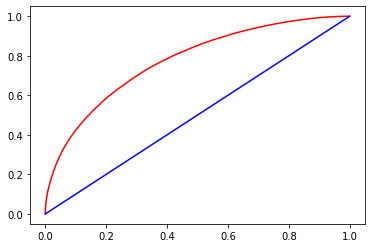

Testing:
ROC AUC score: 0.7164782489947419
ROC AUC curve:


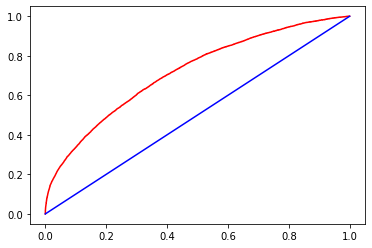

---------------
Round number 1
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 10.222824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20531
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9637
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7748618271133653
ROC AUC curve:


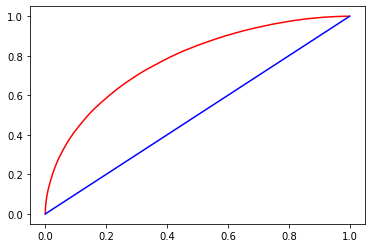

Testing:
ROC AUC score: 0.7104832504799802
ROC AUC curve:


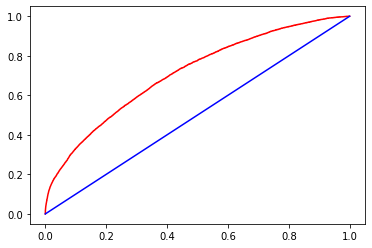

---------------
Round number 2
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 9.166922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20521
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9636
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7751732205754422
ROC AUC curve:


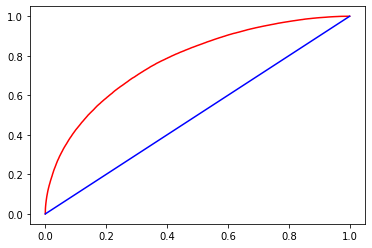

Testing:
ROC AUC score: 0.7066901870409619
ROC AUC curve:


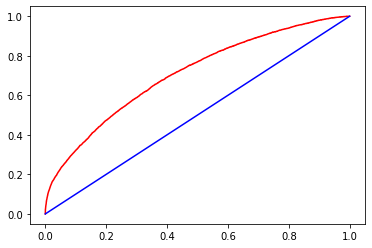

---------------
Round number 3
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 6.679297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20555
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9651
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7751104684808141
ROC AUC curve:


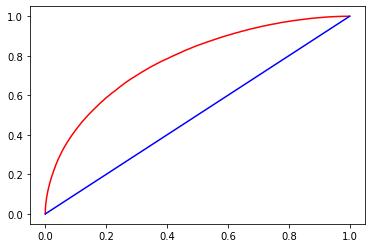

Testing:
ROC AUC score: 0.7121265285786423
ROC AUC curve:


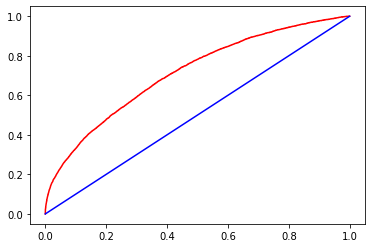

---------------
Round number 4
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 9.235773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20597
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9669
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7746816279529672
ROC AUC curve:


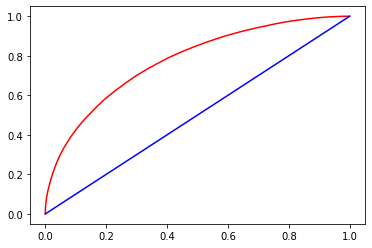

Testing:
ROC AUC score: 0.7114402858178128
ROC AUC curve:


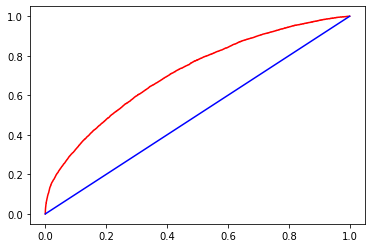

---------------
Round number 5
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 9.162928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20479
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9614
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7741831301537924
ROC AUC curve:


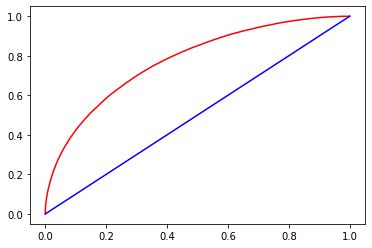

Testing:
ROC AUC score: 0.7093431666212003
ROC AUC curve:


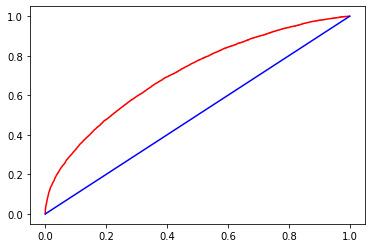

---------------
Round number 6
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 10.721925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20480
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9613
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7747937405242588
ROC AUC curve:


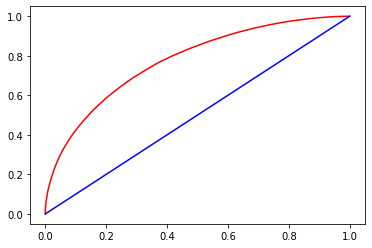

Testing:
ROC AUC score: 0.7090869059919154
ROC AUC curve:


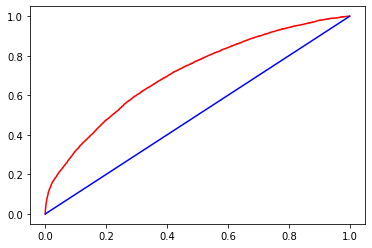

---------------
Round number 7
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 8.015152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20490
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9618
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7744993169702394
ROC AUC curve:


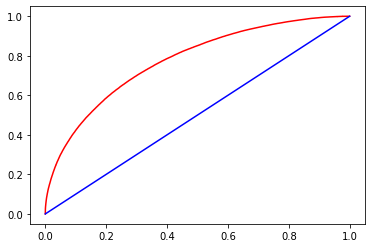

Testing:
ROC AUC score: 0.7112006449478905
ROC AUC curve:


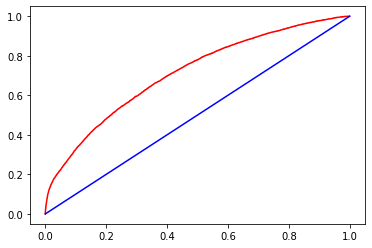

---------------
Round number 8
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 10.150547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20451
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9598
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.775117820617073
ROC AUC curve:


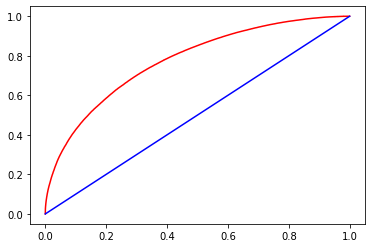

Testing:
ROC AUC score: 0.7092758334789854
ROC AUC curve:


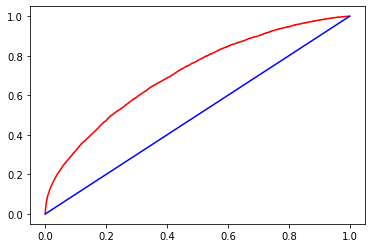

---------------
Round number 9
[LightGBM] [Info] Number of positive: 76643, number of negative: 434314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 6.725399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20465
[LightGBM] [Info] Number of data points in the train set: 510957, number of used features: 9607
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734609
[LightGBM] [Info] Start training from score -1.734609


Training:
ROC AUC score: 0.7754982680992734
ROC AUC curve:


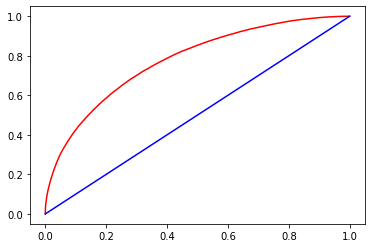

Testing:
ROC AUC score: 0.7088549922150906
ROC AUC curve:


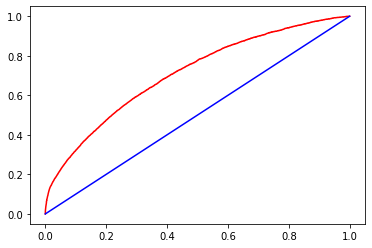

---------------
Mean validation AUROC: 0.7104980044167221
Median validation AUROC: 0.7099132085505903
Min validation AUROC: 0.7066901870409619
Max validation AUROC: 0.7164782489947419


In [35]:
cross_validate(model,10, train_X, train_Y)

model = lgb.LGBMClassifier(num_leaves=16, learning_rate=0.07, n_estimators=2000, silent=False)

Mean validation AUROC: 0.7104980044167221

Median validation AUROC: 0.7099132085505903

Min validation AUROC: 0.7066901870409619

Max validation AUROC: 0.7164782489947419

## Testset Write

In [36]:
model.fit(train_X, train_Y)


[LightGBM] [Info] Number of positive: 85159, number of negative: 482571
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.382868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20434
[LightGBM] [Info] Number of data points in the train set: 567730, number of used features: 9589
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149999 -> initscore=-1.734608
[LightGBM] [Info] Start training from score -1.734608


LGBMClassifier(learning_rate=0.07, n_estimators=2000, num_leaves=16,
               silent=False)

In [37]:
test_Yhat = model.predict_proba(test_X)[:,1]

In [39]:
test_dset_df  = pd.read_csv("./datasets/test.csv")
test_dset_df = test_dset_df.loc[:,["MachineIdentifier"]]
test_dset_df["HasDetections"] = test_Yhat
test_dset_df.to_csv("AKB2020_11_30a_output.csv", index=False)

/home/akb/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
